In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using DifferentialEquations: DP5, Tsit5, Vern7, Vern9, BS3
using Random
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

false

In [28]:
bs = SpinBasis(1//2)
sigmoid(x) = 0.8/(exp(-x)+1)
n_neurons = 8
Random.seed!(1)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 1, sigmoid))
θ = Vector{Float64}(initial_params(ann));
println(length(θ))

241


In [29]:
(t0, t1)=(0.0, 5.0)

tsf32 = Float32(t0):Float32(t1/39):Float32(t1)
Ωs = Vector{Float32}(vcat([0.0, 0.1], 0.2*ones(36), [0.1, 0.0]))
ts = Vector{Float64}(tsf32)
function loss(p)
    c = 0.0f0
    for (i,t) in enumerate(tsf32)
        x = ann([t], p) + ann([Float32(t1)-t], p)
        c += (x[1] - Ωs[i])^2
    end
    #println(c)
    c
end
res = DiffEqFlux.sciml_train(loss, initial_params(ann), ADAM(0.1f0), maxiters = 1500)
θ = Vector{Float64}(res.u);

In [46]:
coeffs(params, t) = ann([t], params)[1] + ann([t1-t], params)[1]
bcs(params) = (ann([t0], params)[1]^2 + ann([t1], params)[1]^2)
                 
cost = CostFunction((x,y)-> 1.0-imag(x'*y), bcs)

CostFunction(var"#9#10"(), bcs)

In [47]:
trans = StateTransform(spindown(bs)=>spinup(bs));

In [48]:
tspan = (t0, t1)
H = Hamiltonian(-0.5*sigmaz(bs), [sigmax(bs)], coeffs)
prob = QOCProblem(H, trans, tspan, cost);

In [58]:
@time sol = solve(prob, θ, ADAM(0.005), Tsit5(), 200;
                  abstol=1e-5, reltol=1e-5)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16
  distance:    0.00459703989902982
  contraints:  0.0028839424907197674


 76.830662 seconds (87.05 M allocations: 13.022 GiB, 86.06% gc time)


Solution{Float64}([-1.9586703382203527, -1.9933533157666534, 1.2566072801329555, 0.5337651494459282, -1.097045208654518, -0.13260434239251487, -0.016175308842540377, -0.780118065441256, 0.014879452196339803, -0.22761406940145834  …  0.5237819181478631, -1.155995294910837, -1.0533998368080115, -1.3350641359303193, 1.3316755708797985, -1.7580018926417367, -0.8911194608936263, -0.5717514445869047, 1.1340737036588497, -0.4990948778794273], [1.2053221539818084, 1.188304142246628, 1.1725004408463353, 1.1594799345372195, 1.1491165364973486, 1.1395490920574005, 1.130325494600691, 1.1213025062665483, 1.1123390699201967, 1.1036516160412944  …  0.008712459159496477, 0.008144594883606637, 0.007693281968826682, 0.0072844118518343715, 0.0068205210835569074, 0.006438031309646708, 0.0059951298254447005, 0.0054967598684456664, 0.005078724830277048, 0.00459703989902982])

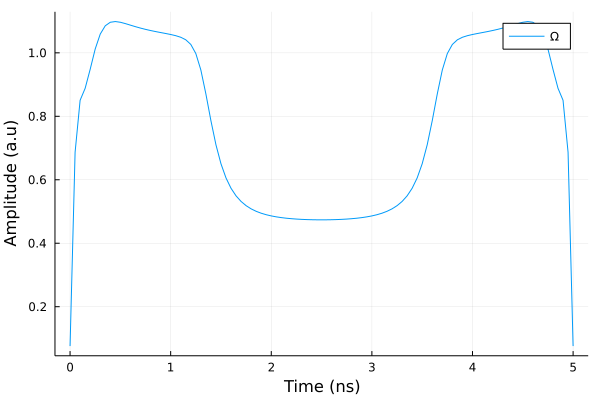

In [59]:
ts = t0:t1/100:t1
Ω(t) = coeffs(sol.params, t)[1]
f = plot(ts, Ω.(ts), label="Ω")
xlabel!("Time (ns)")
ylabel!("Amplitude (a.u)")

In [60]:
tout, psit = schroedinger_dynamic(ts, spindown(bs), H, sol.params);

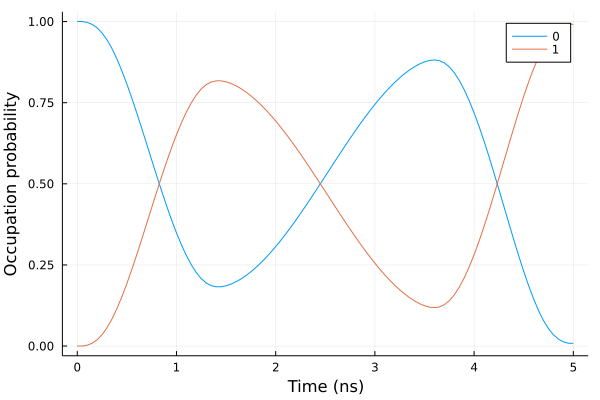

In [61]:
f = plot()
plot!(f, tout, real(expect(dm(spindown(bs)), psit)), label=string(0))
plot!(f, tout, real(expect(dm(spinup(bs)), psit)), label=string(1))
ylabel!(f, "Occupation probability")
xlabel!(f, "Time (ns)")
f